# Ensemble learning and Random Forests

## Voting Classifiers
* Train multiple classifiers on the training set (possibly the same or subsets - more later) and construct an ensemble classifier by e.g. a mode (the most frequent output)
* Typically performs better than individual classifiers - follows from the law of large numbers (the more classifiers the better)
* But using the same training set is problematic as individual classifiers might be correlated (not iid) - classifiers will learn the same mistakes, especially when all implement the same learning algorithm
* Regression works similarly and typically uses mean instead of statistical mode for the final output

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=10_000, noise=0.4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svc_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svc_clf)],
    voting='hard',
)

for clf in (log_clf, rnd_clf, svc_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.839
RandomForestClassifier 0.8615
SVC 0.868
VotingClassifier 0.868


## Bagging and Pasting
* The idea here is to prevent correlation by splitting the training set into subsets and training each predictor (all of one type) on one subset
* When the subset sampling is done *with replacement* then we call this technique **bagging** (in statistics also called **bootstrap**), when it's done *without replacement* we call it **pasting**
* Aggregate model should in theory generalize better - the reasoning here is that we trade increased bias (because we use many models of the same type) for lower variance (because of splitting the training set and using aggregation)

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8705

### Out-of-Bag Evaluation
Because bootstrap samples (with replacement) out of all $m$ training just some into each taining sub-set it means that only about 63% on average of all the training instances will sampled for some predictor. The rest, which is never sampled, is called *out-of-bag* instances.

The idea here is that we can use OOB instances as a free validation set because it is likely that each training instance will be OOB for several estimators. *Scikit-Learn* can automatically collect OOB score during training.

In [3]:
bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.83875

In [4]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.86

In [5]:
bag_clf.oob_decision_function_

array([[1.        , 0.        ],
       [0.03684211, 0.96315789],
       [0.6344086 , 0.3655914 ],
       ...,
       [0.92021277, 0.07978723],
       [0.89784946, 0.10215054],
       [0.15425532, 0.84574468]])

### Random Patches and Random Subspaces

Another variant (or rather extension) of a bagging classifier is sampling features as well as training instances.
* *Random patches* - sample both features and instances
* *Random subspaces* - sample features but keep all instance (set `bootstrap=False, max_samples=1.0`, `bootstrap_features=True` and/or `max_features` to less than 1

In *Scikit-Learn* one can control feature sampling with `bootstrap_features` and `max_features` which works similarly to `bootstrap` and `max_samples`.

## Random Forests

In *Scikit-Learn* it's basically a convenience API for a begging (sometimes pasting) classifier/regressor.

In [6]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

# Equivalent to:
# bag_clf = BaggingClassifier(
#     base_estimator=DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
#     n_estimators=500,
#     max_samples=1.0,
#     bootstrap=True,
#     n_jobs=-1,
# )

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.8675

### Feature Importance

Random forests have a nice property that they can easily estimate feature importance by looking at how much the tree nodes using a feature reduce impurity on average (over all trees in the forest, weighted by the leaf sample size).

In [7]:
from sklearn.datasets import load_iris

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09150843011552325
sepal width (cm) 0.022125152106630883
petal length (cm) 0.4380628768059563
petal width (cm) 0.4483035409718895


## Boosting
Technique which trains a strong predictor by sequentially improving weak predictors. Typical eamples are:
* **AdaBoos** - adaptive boosting, each training sample is assigned a weight - base classifiers are trained on these weighted samples and combined (weighted) into final predictor
* **Gradient Boosting** - similar to *AdaBoost* but consecutive weak predictors (after the first one) are trained on residual errors of the previous one, final predictor is simple sum of all weak ones

### AdaBoost
The main idea is to sequentially train weak predictors and combine them into strong one. Each training sample is assigned a weight $w^{(i)}$ initialized to $1/m$. The weighted error rate of $j^{th}$ predictor is
$
r_j = \frac{\sum_{i = 1, \hat{y}_j^{(i)} = y^{(i)}}^m w^{(i)}}{\sum_{i = 1}^m w^{(i)}}
$

Next, each predictor is assigned a weight $\alpha_j$ computed from it's error rate ($\eta$ is a learning rate hyper-parameter): $\alpha_j = \eta \log{\frac{1 - r_j}{r_j}}$.

The iteration is concluded by updating sample weights as follows: 
$
w^{(i)} = 
    \begin{cases}
       w^{(i)} & \quad \text{if } \hat{y}_j^{(i)} = y^{(i)}\\
       w^{(i)}\exp(\alpha_j) & \quad \text{if } \hat{y}_j^{(i)} \ne y^{(i)}
    \end{cases}
$

Final predictor is combined from all intermediate predictors as $\hat{y}(\mathbf{x}) = \text{argmax}_k \sum_{j = 1, \hat{y}_j(\mathbf{x}) = k}^N \alpha_j$ where $N$ is the number of iterations (weak predictors).

*Scikit-Learn* by default uses *Decision Stumps* as base predictors - decision trees with single decision node.

In [8]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm='SAMME.R',
    learning_rate=0.5,
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### Gradient Boosting
As described above, the idea is quite simple:
1. train initial predictor on the training set targets
2. train consecutive predictors to target the residual errors of the previous predictor
3. after convergence return a combination (sum) of all predictors in the sequence

This is how one would do it manually:

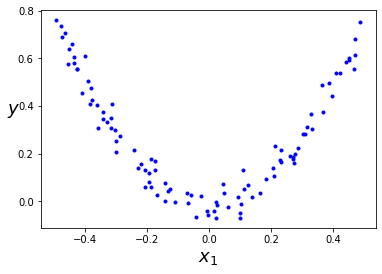

In [9]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.show()

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])

y_pred = np.sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

gbrt.predict(X_new)

array([0.75026781])

One can use early stopping strategy to find the best number of estimators. First version below generates all the trees (estimators) first and then searches for the best setting whereas the next version implements real early stopping - does not generate more trees if the validation error does not drop for some number of steps.

In [12]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=85)

In [13]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

max_steps_going_up = 5

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == max_steps_going_up:
            break  # early stopping
            
gbrt

GradientBoostingRegressor(max_depth=2, n_estimators=69, warm_start=True)

#### XGBoost
*XGBoost* is specialized library for gradient boosting with API similar to *Scikit-Learn*. One of many nice things about it is that it implements early stopping out of the box.

In [14]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

y_pred = xgb_reg.predict(X_val)
mean_squared_error(y_val, y_pred)

[0]	validation_0-rmse:0.22055
[1]	validation_0-rmse:0.16547
[2]	validation_0-rmse:0.12243
[3]	validation_0-rmse:0.10044
[4]	validation_0-rmse:0.08467
[5]	validation_0-rmse:0.07344
[6]	validation_0-rmse:0.06728
[7]	validation_0-rmse:0.06383
[8]	validation_0-rmse:0.06125
[9]	validation_0-rmse:0.05959
[10]	validation_0-rmse:0.05902
[11]	validation_0-rmse:0.05852
[12]	validation_0-rmse:0.05844
[13]	validation_0-rmse:0.05801
[14]	validation_0-rmse:0.05747
[15]	validation_0-rmse:0.05772


0.0033024085351185672

## Stacking
The idea behind stacking is instead of hard voting tain another predictor to aggregate the predictors in an ensemble. Tere are two approaches how to train the ensemble:
1. Split the training set into two sub-sets, first is used to train base predictors, the other (*hold-out set*) is used to create predictions of base estimators to create a training set for the *blender* (this is called **blending**)
2. Alternatively, it is possible to use *out-of-fold* predictions - this is called **stacking**

Note that this approach can be easily extended to more than just one layer by splitting the training set into multiple times and repeating what's described above. *Scikit-Learn* does not implement this out of the box but there are good libraries for it - e.g. [DESlib](https://github.com/scikit-learn-contrib/DESlib).

## Exercises

In [16]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)

X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10_000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10_000, random_state=42)

### Voting Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)

In [42]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf]

for estimator in estimators:
    print('Training the', estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(random_state=42)


In [43]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8695]

In [44]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators = [
        ("random_forest_clf", random_forest_clf),
        ("extra_trees_clf", extra_trees_clf),
        ("svm_clf", svm_clf),
    ]
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', LinearSVC(random_state=42))])

In [45]:
voting_clf.score(X_val, y_val)

0.9699

In [46]:
[estimator.score(X_val, y_val) for _, estimator in voting_clf.estimators]

[0.9692, 0.9715, 0.8695]

Let's try it without the SVM

In [47]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None)])

In [48]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None)]

In [49]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(random_state=42)]

In [50]:
del voting_clf.estimators_[2]
del voting_clf.estimators[2]

In [51]:
voting_clf.score(X_val, y_val)

0.9713

In [52]:
voting_clf.voting = "soft"
voting_clf.score(X_val, y_val)

0.9719

In [53]:
[estimator.score(X_test, y_test) for _, estimator in voting_clf.estimators]

[0.9645, 0.9691]

### Stacking Ensemble

In [54]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for i, estimator in enumerate(estimators):
    X_val_predictions[:, i] = estimator.predict(X_val)
    
X_val_predictions

array([[5., 5., 5.],
       [8., 8., 8.],
       [2., 2., 2.],
       ...,
       [7., 7., 7.],
       [6., 6., 6.],
       [7., 7., 7.]], dtype=float32)

In [55]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [56]:
rnd_forest_blender.oob_score_

0.9698

In [57]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for i, estimator in enumerate(estimators):
    X_test_predictions[:, i] = estimator.predict(X_test)

In [58]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [59]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9665